# Grammarly Case Study

First of all, we will install one library to make sure we can use sql within the jupyter notebook and make sure we can import the dataset for this study.

## Downloading the Data and Importing Libraries

In [72]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
from datetime import datetime

In [55]:
### The df will enable us to use python incase we need it
df = pd.read_csv(os.path.join('datasets', 'dataset_gbAnalyst_dataExercise.csv'))

### This will enable us to use sql syntax and create the respective database.
conn = sqlite3.connect('Grammarly.db')
c = conn.cursor()

# Create table - LEADS
c.execute('''CREATE TABLE LEADS
             ([generated_id] INTEGER PRIMARY KEY,
              [id] integer, 
              [lead_status] text, 
              [creation_date] date,
              [status_change] date,
              [lead_source] text,
              [deal_size] integer,
              [company_size] text,
              [company_industry] text)''')

# Insert the values from the csv file into the table 'LEADS'
df.to_sql('LEADS', conn, if_exists='append', index = False) 

Let's check if we were successful on creating the SQL Database

In [56]:
pd.io.sql.read_sql('''
    SELECT *
    FROM LEADS
    LIMIT 5
          ''', con = conn)

,generated_id,id,lead_status,creation_date,status_change,lead_source,deal_size,company_size,company_industry
0,1,25691639,qualification,2020-03-30,2020-03-31,paid_ads,112,251-500,Commerce and Shopping|Financial Services|Infor...
1,2,66519272,rejected,2019-12-24,2019-12-24,paid_ads,428,5001-10000,Data and Analytics|Information Technology|Mobi...
2,3,102989944,converted,2019-09-14,2020-01-05,paid_ads,87,501-1000,Financial Services
3,4,244285609,rejected,2020-01-27,2020-01-27,consumer_website,128,251-500,Legal
4,5,255755011,rejected,2020-03-12,2020-03-12,paid_ads,245,251-500,Legal


## Performing some simple exploratory analysis on the Leads acquired on 2020

Now that we are able to use sql, we will try to understand the type of data we are dealing with and explore some opportunities or problems we might be currently facing.

### Total Leads

Using a quick SQL query, let's first check the number of duplicate ids and then not take them into consideration for this analysis. Since, I'm lacking context on how to handle those anomalies. 

In [60]:
pd.io.sql.read_sql('''
    WITH DuplicateIds AS (
        SELECT id, count(*) AS number_of_appearance
        FROM LEADS
        GROUP BY 1 
        HAVING count(*) > 1
    )
    
    SELECT count(distinct LEADS.id) AS number_of_new_leads
    FROM LEADS
    LEFT JOIN DuplicateIds ON LEADS.id = DuplicateIds.id
    WHERE creation_date >= date('2020-01-01')
      AND DuplicateIds.id IS NULL
          ''', con = conn)

,number_of_new_leads
0,45282


By removing the duplicates, we see that we have a total of 45,282 new leads in 2020. Let's check the breakdown of those new lead by their current status. I'll be using python for the next bit, to calculate the breakdown.

### Leads Breakdown by Lead Status 

In [65]:
year_2020 = datetime.strptime('2020-01-01', '%Y-%m-%d').date()

### Changing the data type to datetime to be able to grab only elements from 2020 and removing duplicates.
df = df.drop_duplicates(subset=['id'], keep=False)
df['creation_date'] = pd.to_datetime(df['creation_date'])
df['status_change'] = pd.to_datetime(df['status_change'])
df_2020 = df[df['creation_date'].dt.date >= year_2020]

In [66]:
df_2020['lead_status'].value_counts() / len(df_2020)

converted        0.433594
rejected         0.392098
qualification    0.087607
new              0.086701
Name: lead_status, dtype: float64

At first glance, it is pretty alarming to see that 39% of our new leads in 2020 ended up being rejected. Meanwhile, we have 43% of our new leads being converted. It would be interesting to check if those that were rejected came from leads acquired recently or at the beggining of the year.

### MoM trend by Lead Status

In [91]:
month_breakdown = pd.io.sql.read_sql('''
    WITH DuplicateIds AS (
        SELECT id, count(*) AS number_of_appearance
        FROM LEADS
        GROUP BY 1 
        HAVING count(*) > 1
    )

    SELECT strftime('%m',creation_date) AS month_created,
           lead_status,
           count(distinct LEADS.id) AS number_of_new_leads
    FROM LEADS
    LEFT JOIN DuplicateIds ON LEADS.id = DuplicateIds.id
    WHERE creation_date >= date('2020-01-01')
      AND DuplicateIds.id IS NULL
      AND lead_status IN ('converted', 'rejected')
    GROUP BY 1,2
          ''', con = conn)
### This part is the equivalent of the Lag function in sql, since I'm using sqlite3 in python
### i don't believe it is still implemented yet.
month_breakdown['previous_month'] = month_breakdown.groupby(['lead_status'])['number_of_new_leads'].shift(periods=1)
month_breakdown['growth_rate'] = (month_breakdown['number_of_new_leads'] - month_breakdown['previous_month']) / month_breakdown['previous_month']
month_breakdown

,month_created,lead_status,number_of_new_leads,previous_month,growth_rate
0,01,converted,4893,NaN,NaN
1,01,rejected,4387,NaN,NaN
2,02,converted,4975,4893.0,0.016759
3,02,rejected,4640,4387.0,0.057670
4,03,converted,5231,4975.0,0.051457
5,03,rejected,4628,4640.0,-0.002586
6,04,converted,4535,5231.0,-0.133053
7,04,rejected,4100,4628.0,-0.114088


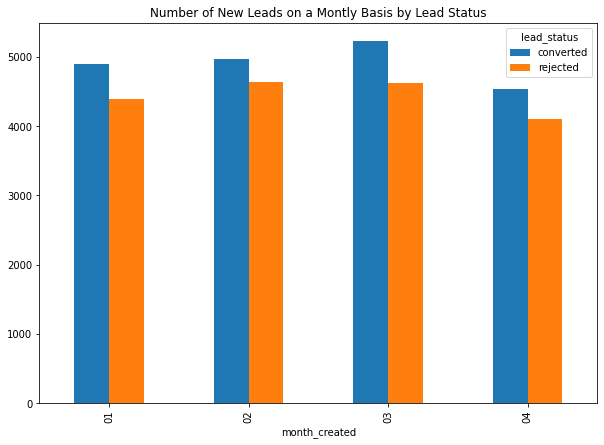

In [95]:
month_breakdown.groupby(['month_created', 'lead_status']).sum().unstack().plot(
    y='number_of_new_leads',
    title='Number of New Leads on a Montly Basis by Lead Status',
    kind='bar', 
    stacked=False,
    figsize=(10,7))

In [109]:
month_breakdown[["lead_status","growth_rate"]].dropna().groupby(['lead_status']).mean()

,growth_rate
lead_status,
converted,-0.021612
rejected,-0.019668


It's currently hard to tell with the information given if there is soom kind of trend and it doesn't seem to have any outlier or something that immediately caughts the attention. Also the average growth rate of the past 3 months (Febraury, March and April) for both groups oscillate around -2%, meaning we are currently experiencing a decline among those two groups. Maybe it would be better to disect the information based on the sector and size of the company to understand if there is an immediate action we can take to increase the number of leads being converted and identify what sector are frequently being rejected.

### Lead Status by Company Sector

In [115]:
df_2020['company_sector'] = df_2020['company_industry'].str.split(pat='|', expand=True).iloc[:,0]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [164]:
df_2020_pie = df_2020[['company_sector','lead_status','id']].groupby(['company_sector','lead_status']).count()
df_2020_pie = df_2020_pie.reset_index()
df_2020_pie_conv = df_2020_pie[df_2020_pie['lead_status'] == 'converted'].set_index('company_sector')
df_2020_pie_rej = df_2020_pie[df_2020_pie['lead_status'] == 'rejected'].set_index('company_sector')
df_2020_pie_conv['converted'] = df_2020_pie_conv.id.values
df_2020_pie_rej['rejected'] = df_2020_pie_rej.id.values
df_2020_pie = pd.concat([df_2020_pie_conv, df_2020_pie_rej], axis=1, sort=False)
df_2020_pie = df_2020_pie[['converted','rejected']].fillna(0)

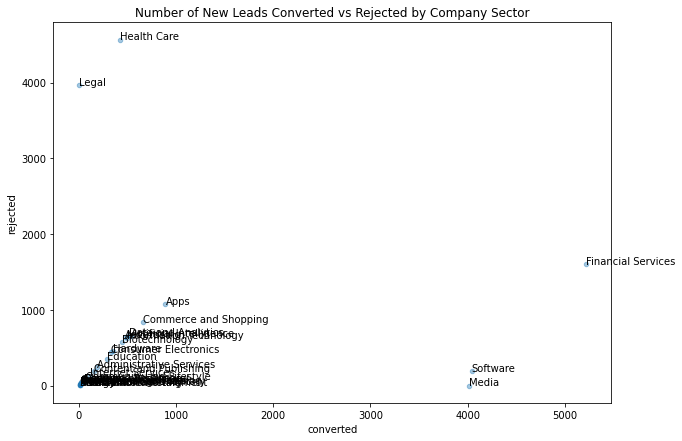

In [165]:
ax = df_2020_pie.plot.scatter(
    x="converted", 
    y="rejected",
    title="Number of New Leads Converted vs Rejected by Company Sector",
    alpha=0.4,
    figsize=(10,7))
for i, txt in enumerate(df_2020_pie.index):
    ax.annotate(txt, (df_2020_pie.converted.iat[i],df_2020_pie.rejected.iat[i]))
plt.show()

In [168]:
anomalous_sectors = ['Health Care', 'Financial Services', 'Legal', 'Software', 'Media']

df_2020_pie[df_2020_pie.index.isin(anomalous_sectors)]

,converted,rejected
Financial Services,5216.0,1606.0
Health Care,420.0,4567.0
Media,4014.0,0.0
Software,4040.0,186.0
Legal,0.0,3964.0


In [218]:
pd.io.sql.read_sql('''
    WITH DuplicateIds AS (
        SELECT id, count(*) AS number_of_appearance
        FROM LEADS
        GROUP BY 1 
        HAVING count(*) > 1
    )
    
    SELECT COUNT(*)
    FROM LEADS
    LEFT JOIN DuplicateIds ON LEADS.id = DuplicateIds.id
    WHERE creation_date >= date('2020-01-01')
      AND DuplicateIds.id IS NULL
      AND (company_industry LIKE 'Financial Services%'
      OR company_industry LIKE 'Health Care%'
      OR company_industry LIKE 'Media|%'
      OR company_industry LIKE 'Media'
      OR company_industry LIKE 'Software%'
      OR company_industry LIKE 'Legal%')
          ''', con = conn)

,COUNT(*)
0,25861


In [181]:
df_2020_anomaly = df_2020[df_2020.company_sector.isin(anomalous_sectors)]
df_2020_non_anomaly = df_2020[~df_2020.company_sector.isin(anomalous_sectors)]
df_2020_anomaly['lead_status'].value_counts() / len(df_2020_anomaly)

converted        0.529369
rejected         0.399172
new              0.036077
qualification    0.035381
Name: lead_status, dtype: float64

In [219]:
df_2020_non_anomaly['lead_status'].value_counts() / len(df_2020_non_anomaly)

rejected         0.382679
converted        0.306060
qualification    0.157149
new              0.154112
Name: lead_status, dtype: float64

It's really palpable the anomalies seen through the scatterplot. We can pinpoint that leads belonging to the following sectors Financial Services, Health Care, Media, Legal and Software have experience either an astounding number of rejections or conversions. Meanwhile the other sectors seems to follow a trend as shown in the scatter plot below.

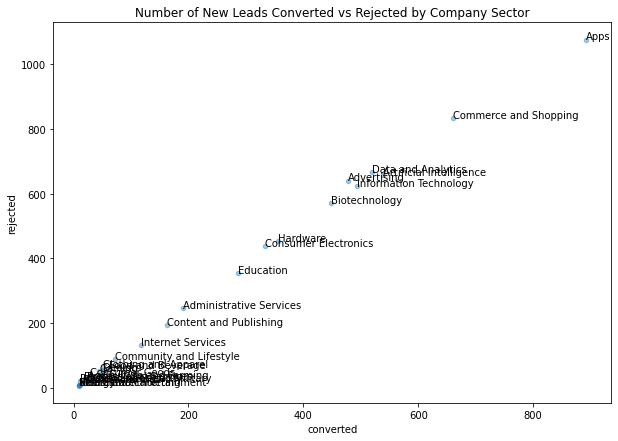

In [220]:
df_2020_pie = df_2020_non_anomaly[['company_sector','lead_status','id']].groupby(['company_sector','lead_status']).count()
df_2020_pie = df_2020_pie.reset_index()
df_2020_pie_conv = df_2020_pie[df_2020_pie['lead_status'] == 'converted'].set_index('company_sector')
df_2020_pie_rej = df_2020_pie[df_2020_pie['lead_status'] == 'rejected'].set_index('company_sector')
df_2020_pie_conv['converted'] = df_2020_pie_conv.id.values
df_2020_pie_rej['rejected'] = df_2020_pie_rej.id.values
df_2020_pie = pd.concat([df_2020_pie_conv, df_2020_pie_rej], axis=1, sort=False)
df_2020_pie = df_2020_pie[['converted','rejected']].fillna(0)

ax = df_2020_pie.plot.scatter(
    x="converted", 
    y="rejected",
    title="Number of New Leads Converted vs Rejected by Company Sector",
    alpha=0.4,
    figsize=(10,7))
for i, txt in enumerate(df_2020_pie.index):
    ax.annotate(txt, (df_2020_pie.converted.iat[i],df_2020_pie.rejected.iat[i]))
plt.show()

### Deal Size for Converted Leads by Non Anomalous Sectors and it's top lead source

In [223]:
import seaborn as sns
import matplotlib.pyplot as plt

conv_non_anomaly = df_2020_non_anomaly[df_2020_non_anomaly['lead_status'] == 'converted']

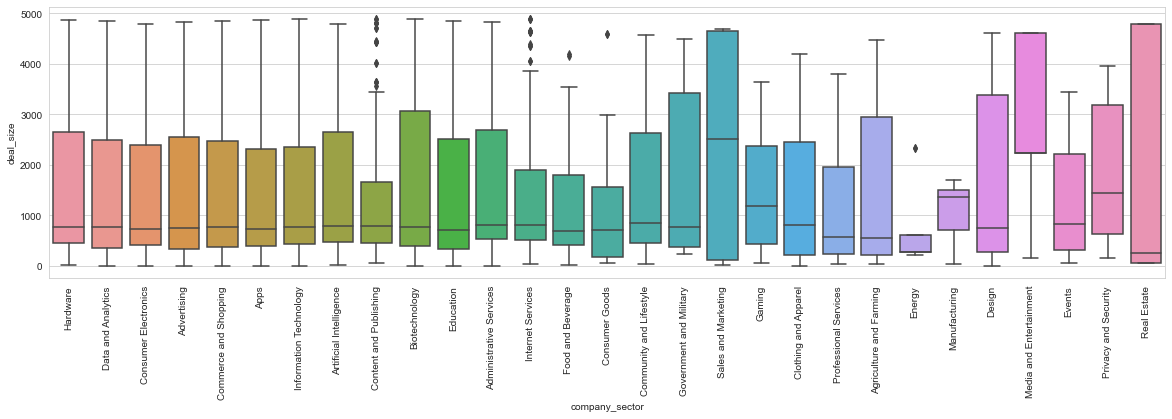

In [244]:
plt.figure(figsize=(20,5))
sns.set_style("whitegrid")
ax = sns.boxplot(
    x=conv_non_anomaly["company_sector"], 
    y=conv_non_anomaly["deal_size"]
);
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

In [245]:
grouped = conv_non_anomaly[['company_sector', 'deal_size']].groupby('company_sector').sum()/sum(conv_non_anomaly.deal_size.values)
grouped.sort_values('deal_size', ascending=False).head()

,deal_size
company_sector,
Apps,0.141565
Commerce and Shopping,0.112172
Artificial Intelligence,0.094883
Data and Analytics,0.089164
Biotechnology,0.084439


As we can see above we know that the companies that generate most of our converted deals belong to the followin sectors: Apps, Commerce and Shopping, Artificial Intelligence, Data and Analytics and Biotechnology. However, when looking at the box plot, we can see that there might be potential in Media and Entertainment since 75% of their leads have deal sizes between 2,300 and 4,600 approximately, which its distribution ranges between higher numbers when compare to the other sectors. Now let's look what would be the best way to target those sectors based on the source they previously where created by.

### Consumer Website vs Paid Ads Source

In [279]:
potential_sectors = ['Apps', 'Commerce and Shopping', 
                     'Artificial Intelligence', 'Data and Analytics',
                     'Biotechnology', 'Media and Entertainment']

source_nona = df_2020_non_anomaly[(df_2020_non_anomaly.company_sector.isin(potential_sectors)) &
                                  (df_2020_non_anomaly.lead_status.isin(['converted', 'rejected']))]

In [293]:
grouped = source_nona[['lead_source','lead_status','company_sector','id']].groupby(['lead_source','lead_status','company_sector']).count()
grouped = grouped.reset_index()

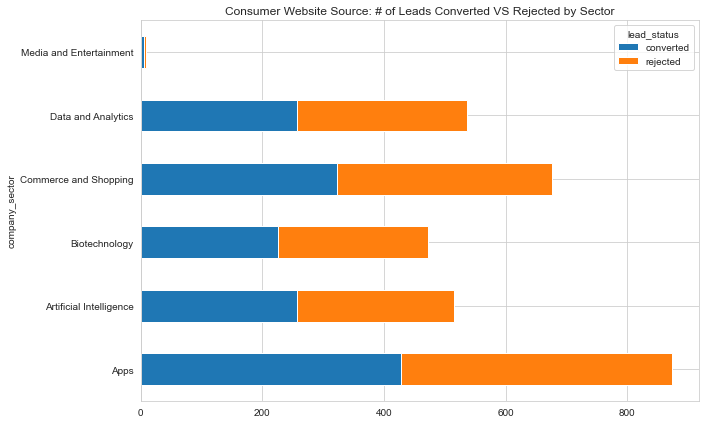

In [298]:
grouped[grouped['lead_source'] == 'consumer_website'].groupby(['company_sector', 'lead_status']).sum().unstack().plot(
    y='id',
    title='Consumer Website Source: # of Leads Converted VS Rejected by Sector',
    kind='barh', 
    stacked=True,
    figsize=(10,7))

In [296]:
grouped[grouped['lead_source'] == 'consumer_website'][['id', 'lead_status']].groupby(['lead_status']).sum() /sum(grouped[grouped['lead_source'] == 'consumer_website'].id.values)

,id
lead_status,
converted,0.484917
rejected,0.515083


In [297]:
grouped[grouped['lead_source'] == 'paid_ads'][['id', 'lead_status']].groupby(['lead_status']).sum() /sum(grouped[grouped['lead_source'] == 'paid_ads'].id.values)

,id
lead_status,
converted,0.414165
rejected,0.585835


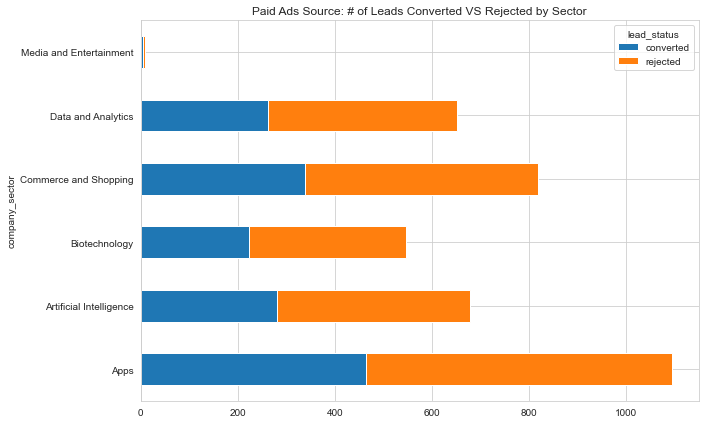

In [299]:
grouped[grouped['lead_source'] == 'paid_ads'].groupby(['company_sector', 'lead_status']).sum().unstack().plot(
    y='id',
    title='Paid Ads Source: # of Leads Converted VS Rejected by Sector',
    kind='barh', 
    stacked=True,
    figsize=(10,7))

### MoM Trend by Lead Status (Non Anomalous Sector)

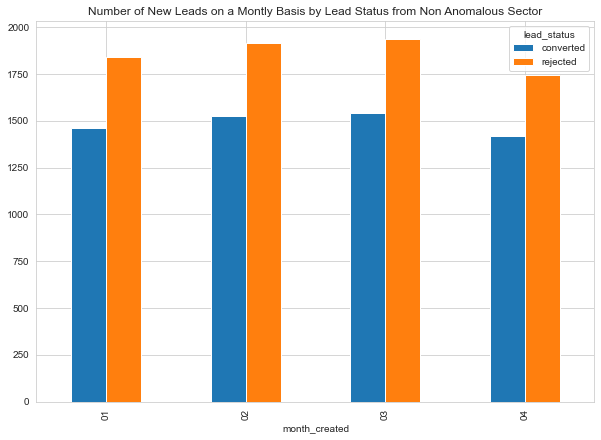

In [274]:
month_breakdown = pd.io.sql.read_sql('''
    WITH DuplicateIds AS (
        SELECT id, count(*) AS number_of_appearance
        FROM LEADS
        GROUP BY 1 
        HAVING count(*) > 1
    )

    SELECT strftime('%m',creation_date) AS month_created,
           lead_status,
           count(distinct LEADS.id) AS number_of_new_leads
    FROM LEADS
    LEFT JOIN DuplicateIds ON LEADS.id = DuplicateIds.id
    WHERE creation_date >= date('2020-01-01')
      AND DuplicateIds.id IS NULL
      AND lead_status IN ('converted', 'rejected')
      AND company_industry NOT LIKE 'Financial Services%'
      AND company_industry NOT LIKE 'Health Care%'
      AND company_industry NOT LIKE 'Media|%'
      AND company_industry NOT LIKE 'Media'
      AND company_industry NOT LIKE 'Software%'
      AND company_industry NOT LIKE 'Legal%'
    GROUP BY 1,2
          ''', con = conn)
### This part is the equivalent of the Lag function in sql, since I'm using sqlite3 in python
### i don't believe it is still implemented yet.
month_breakdown['previous_month'] = month_breakdown.groupby(['lead_status'])['number_of_new_leads'].shift(periods=1)
month_breakdown['growth_rate'] = (month_breakdown['number_of_new_leads'] - month_breakdown['previous_month']) / month_breakdown['previous_month']

month_breakdown.groupby(['month_created', 'lead_status']).sum().unstack().plot(
    y='number_of_new_leads',
    title='Number of New Leads on a Montly Basis by Lead Status from Non Anomalous Sector',
    kind='bar', 
    stacked=False,
    figsize=(10,7))

In [275]:
month_breakdown[["lead_status","growth_rate"]].dropna().groupby(['lead_status']).mean()

,growth_rate
lead_status,
converted,-0.007863
rejected,-0.015624


### MoM Trend by Lead Status (Anomalous Sector)

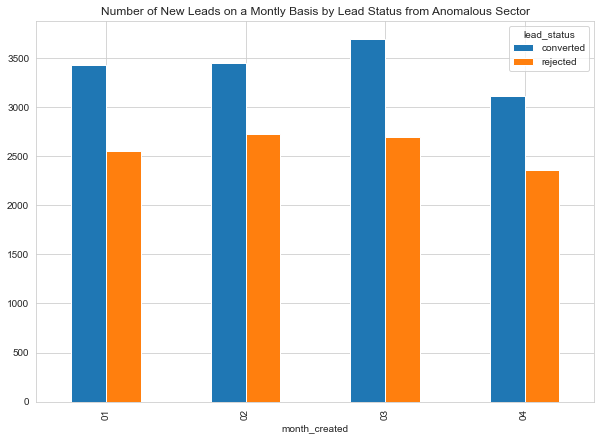

In [278]:
month_breakdown = pd.io.sql.read_sql('''
    WITH DuplicateIds AS (
        SELECT id, count(*) AS number_of_appearance
        FROM LEADS
        GROUP BY 1 
        HAVING count(*) > 1
    )

    SELECT strftime('%m',creation_date) AS month_created,
           lead_status,
           count(distinct LEADS.id) AS number_of_new_leads
    FROM LEADS
    LEFT JOIN DuplicateIds ON LEADS.id = DuplicateIds.id
    WHERE creation_date >= date('2020-01-01')
      AND DuplicateIds.id IS NULL
      AND lead_status IN ('converted', 'rejected')
      AND (company_industry LIKE 'Financial Services%'
      OR company_industry LIKE 'Health Care%'
      OR company_industry LIKE 'Media|%'
      OR company_industry LIKE 'Media'
      OR company_industry LIKE 'Software%'
      OR company_industry LIKE 'Legal%')
    GROUP BY 1,2
          ''', con = conn)
### This part is the equivalent of the Lag function in sql, since I'm using sqlite3 in python
### i don't believe it is still implemented yet.
month_breakdown['previous_month'] = month_breakdown.groupby(['lead_status'])['number_of_new_leads'].shift(periods=1)
month_breakdown['growth_rate'] = (month_breakdown['number_of_new_leads'] - month_breakdown['previous_month']) / month_breakdown['previous_month']

month_breakdown.groupby(['month_created', 'lead_status']).sum().unstack().plot(
    y='number_of_new_leads',
    title='Number of New Leads on a Montly Basis by Lead Status from Anomalous Sector',
    kind='bar', 
    stacked=False,
    figsize=(10,7))

In [277]:
month_breakdown[["lead_status","growth_rate"]].dropna().groupby(['lead_status']).mean()

,growth_rate
lead_status,
converted,-0.027089
rejected,-0.022498
